In [1]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
import pylab as plt
import json
import datetime
import pycrs
import seaborn as sns
from glob import glob
from rasterio.plot import show, show_hist
from rasterio.mask import mask
from shapely.geometry import Point
from shapely.geometry import LineString
sys.path.append('GOSTNets')

import GOSTnet as gn
from pandana.loaders import osm;

from osgeo import gdal, gdalconst, gdal_array
from rasterstats import point_query, zonal_stats
from make_fishnet import make_fishnet

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 


## Functions

In [2]:
def get_amenities(string, tag):
    
    if tag == 'healthcare':
        amenities = ['hospital', 'doctor', 'healthcare', 'clinic']
    elif tag=='schools':
        amenities = ['school', 'university', 'college']
    else:
        print('Invalid tag. Enter either healthcare or schools.')


    osm_tags = '"amenity"~"{}"'.format('|'.join(amenities))

    #pois = osm.node_query(coords[0],coords[1],coords[2],coords[3],tags=osm_tags) # required: lat_min, lng_min, lat_max, lng_max
    
    poly = get_polygon(string) ### minx	miny	maxx	maxy
    
    extent = poly.bounds
    try:
        pois = osm.node_query(extent[1], extent[0], extent[3], extent[2], tags=osm_tags)

        pois = pois[pois['amenity'].isin(amenities)]

        try:
            osm_data = pois[['amenity', 'lat', 'lon', 'name', 'name:en']]
        except:
            osm_data = pois[['amenity', 'lat', 'lon', 'name']]


        osm_data['geometry'] = (list(zip(osm_data.lon,osm_data.lat)))
        osm_data['geometry'] = osm_data.geometry.apply(lambda x: Point(x))
        osm_data = gpd.GeoDataFrame(osm_data, geometry='geometry')

        osm_data.crs = {'init':'epsg:4326'}
        string = str(string)
        print('Saving OSM data to shapefile at path data/{}'.format(string))
    #osm_data.to_file('data/{}/{}_{}.shp'.format(string, string, tag))
    #except HTTPError:
    #    osm_data = gpd.read_file('data/{}/{}_{}.shp'.format(string, string, tag))
    except:
        print('Error occured while fetching OSM data')
        osm_data = None
        pass
    
    return osm_data

In [3]:
def get_polygon(string):
    
    lis = glob('/nfshome/gb1877/gb1877/WorldBank/CRP/Betweenness_Centrality/data/AOI/*/*.shp')
    
    city = []
    for i in lis:
        x = i.split('/')[-2]
        city.append(x.split('_')[0])
        
    if string in city:
        l = glob('/nfshome/gb1877/gb1877/WorldBank/CRP/Betweenness_Centrality/data/AOI/{}_AOI/*.shp'.format(string))
        adm = gpd.GeoDataFrame.from_file(l[0])
        boundary_poly = adm.geometry.values[0]
    else:
        boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=1)
        boundary_poly = boundary_GDF.loc[0,'geometry']
        if boundary_poly.geom_type == 'Polygon':
            boundary_poly = boundary_poly
        else:
            try:
                boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=2)
                boundary_poly = boundary_GDF.loc[0,'geometry']
            except:
                print('Polygon not available')
                boundary_poly =  -1
    
    return boundary_poly

In [4]:
def get_graph(string, boundary_GDF, network_type, target_crs='epsg:3395'):
    
    print('Fetching graph data for {}'.format(string))

    G = ox.graph_from_polygon(get_polygon(string), network_type = network_type)
    #G = ox.project_graph(G, to_crs = {'init': '{}'.format(target_crs)})
    #G_project = ox.project_graph(G_drive, to_crs = {'init':'epsg:28411'} )
    node_dict = {}

    G2 = G.copy()

    for u, data in G2.nodes(data = True):
        node_dict[u] = Point(data['x'],data['y'])

    for u, v, data in G2.edges(data = True):

        if 'Wkt' not in data.keys():
            strt = node_dict[u]
            fini = node_dict[v]
            data['Wkt'] = LineString([strt, fini])

        if 'geometry' in data.keys():
            data['Wkt'] = data['geometry']
            data.pop('geometry')
            
    importlib.reload(gn)
    G3 = gn.salt_long_lines(G2,
                           source = 'epsg:4326',
                          target = target_crs,
                          thresh = 50,
                          factor = 1)
    
    
    return G3
    

In [5]:
def get_time(t1, t2):
    
    diff = t2 - t1
    
    c = round(diff.total_seconds() / 60, 2)
    
    return c

In [6]:
def get_crs(string):
    
    crs_dict = {
    'Coron' : 'epsg:25391', 'Puerto Princesa': 'epsg:25391', 'El Nido' : 'epsg:25391', 'Davao City' : 'epsg:25391', 
    'Tashkent' : 'epsg:28411', 'Hebron' : 'epsg:2039', 'Bethlehem' : 'epsg:2039', 'Lima' : 'epsg:24891', 'Vinh Long' : 'epsg:2045', 
    'Khanh Hoa' : 'epsg:2045', 'Osh' : 'epsg:7685', 'Monrovia': 'epsg:2137'
    }
    
    return crs_dict['{}'.format(string)]
    

In [7]:
def get_accessibility(place, grid_size=100):
        
    t1= datetime.datetime.now()
    string = place.split(',')[0]

    poly = get_polygon(string)

    if poly == -1:
        boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=2)
        xmin = boundary_GDF.bbox_west[0]
        xmax = boundary_GDF.bbox_east[0]
        ymin = boundary_GDF.bbox_south[0]
        ymax = boundary_GDF.bbox_north[0]
    else:
        bounds = poly.bounds
        xmin = bounds[0]
        xmax = bounds[2]
        ymin = bounds[1]
        ymax = bounds[3]
    
    boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=1)
    
    osm_schools = get_amenities(string, 'schools')
    
    osm_hosp = get_amenities(string, 'healthcare')

    t2 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t2)))
    #### For drive network
    
    crs = get_crs(string)

    G_drive = get_graph(string,boundary_GDF, 'drive', target_crs= crs)
    
    t3 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t3)))
    print('Snapping OSM data to drive network')
    
    osm_schools.set_geometry(col='geometry', crs=crs, inplace=True)
    osm_hosp.set_geometry(col='geometry', crs=crs, inplace=True)
    
    schools = gn.pandana_snap(G_drive, osm_schools, target_crs=crs, add_dist_to_node_col=True)
    
    health = gn.pandana_snap(G_drive, osm_hosp,target_crs=crs,  add_dist_to_node_col=True)
    
    #node_gdf_drive = ox.graph_to_gdfs(G_drive, nodes=True, edges=False)
    #node_gdf_drive = gn.pandana_snap(G_drive, node_gdf_drive)
    
    t4 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t4)))
    
    fail_value = 9999
    
    print('Creating fishnet')
    make_fishnet('data/{a}/{b}_{c}_grid.shp'.format(a=string,b=string, c='fishnet'),xmin, xmax, ymin, ymax,grid_size,grid_size) 
    # takes xmin, xmax, ymin, ymax   
    
    
    grid=gpd.read_file('data/{a}/{b}_{c}_grid.shp'.format(a=string,b=string, c='fishnet'))
    
    grid['centroid'] = grid.geometry.centroid
    grid_graph = grid[['FID', 'centroid']]
    grid_graph.rename(columns = {'centroid':'geometry'}, inplace=True)
    grid_graph = gpd.GeoDataFrame(grid_graph)
    grid_graph.set_geometry(col='geometry', crs=crs, inplace=True)
    
    grid_graph = gn.pandana_snap(G_drive, grid_graph,target_crs=crs,  add_dist_to_node_col=True)
    
    t5 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t5)))
    
    
    importlib.reload(gn)
    print('Calculating OD matrix for drive network')
    #schools_OD_drive = gn.calculate_OD(G=G_drive, origins=list(node_gdf_drive.NN), destinations = list(schools.NN), 
    #                             fail_value = fail_value, weight='time')
    
    #health_OD_drive = gn.calculate_OD(G=G_drive, origins=list(node_gdf_drive.NN), destinations = list(health.NN), 
    #                         fail_value = fail_value, weight='time')
    
    schools_OD_drive = gn.calculate_OD(G=G_drive, origins=list(grid_graph.NN), destinations = list(schools.NN), 
                                 fail_value = fail_value, weight='distance')
    
    health_OD_drive = gn.calculate_OD(G=G_drive, origins=list(grid_graph.NN), destinations = list(health.NN), 
                             fail_value = fail_value, weight='distance')
    
    #node_gdf_drive['distance_school'] = [schools_OD_drive[i].min() for i in range(schools_OD_drive.shape[0])]
    #node_gdf_drive['distance_hospital'] = [health_OD_drive[i].min() for i in range(health_OD_drive.shape[0])]
    
    grid_graph['school_drive'] = [schools_OD_drive[i].min() for i in range(schools_OD_drive.shape[0])]
    grid_graph['hosp_drive'] = [health_OD_drive[i].min() for i in range(health_OD_drive.shape[0])]
    
    grid['school_trans'] = grid_graph['school_drive']
    grid['hosp_trans'] = grid_graph['hosp_drive']
    grid['NN_dist'] = grid_graph.NN_dist
    grid['total_school'] = grid_graph.school_drive + grid_graph.NN_dist
    grid['total_hosp'] = grid_graph.hosp_drive + grid_graph.NN_dist
    
    
    
    grid.drop(columns=['centroid'], inplace=True)
    #grid.crs = {'init':'epsg:4326'}
    grid = grid[grid.total_school != 9999.0]
    print('Writing output file!!')
    grid.to_file('data/{}/Access_School_Hosp_{}_{}.shp'.format(string, string, grid_size))
    print('Done!!!')

In [34]:
get_accessibility('Tashkent, Uzbekistan', 100)

/nfshome/gb1877/.conda/envs/osm2/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nfshome/gb1877/.conda/envs/osm2/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Saving OSM data to shapefile at path data/Tashkent
Saving OSM data to shapefile at path data/Tashkent
0.36 minutes elapsed!
Fetching graph data for Tashkent
peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Identified 17107 unique edge(s) longer than 50. 
Beginning new node creation...
137912 new edges added and 29840 removed to bring total edges to 145276
51849 new nodes added to bring total nodes to 66628
1.82 minutes elapsed!
Snapping OSM data to drive network
2.17 minutes elapsed!
Creating fishnet
3.14 minutes elapsed!
peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Calculating OD matrix for drive network
print origins type
<class 'list'>
weighted_origins equals false
print origins type
<class 'list'>
weighted_origins equals false
Writing output file!!


/nfshome/gb1877/.conda/envs/osm2/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Done!!!


In [8]:
priority_list = [
    'Coron, Philippines', 'Puerto Princesa, Philippines', 'El Nido, Philippines', 'Davao City, Philippines', 
    'Tashkent, Uzbekistan' 'Hebron, West Bank', 'Bethlehem, West Bank', 'Lima, Peru', 'Vinh Long, Vietnam', 
    'Khanh Hoa, Vietnam', 'Osh, Kyrgyzstan', 'Monrovia, Liberia'
]

In [51]:
get_accessibility('Bethlehem, West Bank', 250)

/nfshome/gb1877/.conda/envs/osm2/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nfshome/gb1877/.conda/envs/osm2/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Saving OSM data to shapefile at path data/Bethlehem
Saving OSM data to shapefile at path data/Bethlehem
0.06 minutes elapsed!
Fetching graph data for Bethlehem
peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Identified 3242 unique edge(s) longer than 50. 
Beginning new node creation...
32482 new edges added and 6181 removed to bring total edges to 34614
12999 new nodes added to bring total nodes to 16652
0.45 minutes elapsed!
Snapping OSM data to drive network
0.54 minutes elapsed!
Creating fishnet
0.77 minutes elapsed!
peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Calculating OD matrix for drive network
print origins type
<class 'list'>
weighted_origins equals false
print origins type
<class 'list'>
weighted_origins equals false
Writing output file!!


/nfshome/gb1877/.conda/envs/osm2/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Done!!!


In [52]:
shp2 = gpd.GeoDataFrame.from_file('data/Bethlehem/Access_School_Hosp_Bethlehem_250.shp')

In [51]:
shp_school = gpd.GeoDataFrame.from_file('data/Bethlehem/Bethlehem_schools.shp')

In [53]:
shp2.head()

,FID,school_tra,hosp_trans,NN_dist,total_scho,total_hosp,geometry
0,0,40.0,76.0,4502.123484,4542.123484,4578.123484,"POLYGON ((35.08135986328136 31.74173355102539,..."
1,1,42.0,71.0,4277.701598,4319.701598,4348.701598,"POLYGON ((35.08135986328136 31.73910067059424,..."
2,2,48.0,77.0,4040.891024,4088.891024,4117.891024,"POLYGON ((35.08135986328136 31.73646779016309,..."
3,3,48.0,77.0,3802.793069,3850.793069,3879.793069,"POLYGON ((35.08135986328136 31.73383490973194,..."
4,4,48.0,77.0,3572.692517,3620.692517,3649.692517,"POLYGON ((35.08135986328136 31.73120202930079,..."


NameError: name 'shp_school' is not defined

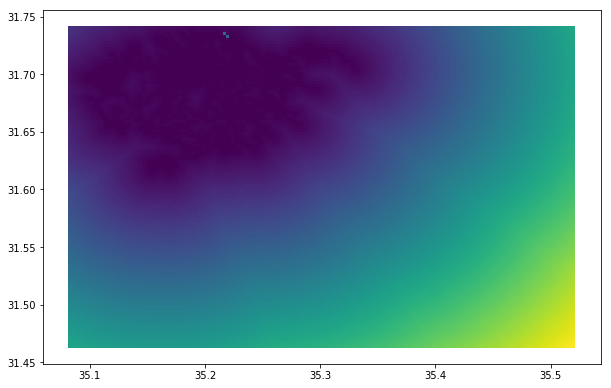

In [47]:
ax = shp2.plot(column='total_scho', cmap='viridis',figsize=[10,10] )
shp_school.plot(color='r', ax=ax)

In [74]:
get_accessibility('Coron, Philippines', 100)

Saving OSM data to shapefile at path data/Coron
Saving OSM data to shapefile at path data/Coron
0.04 minutes elapsed!
Fetching graph data for Coron
peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Identified 101 unique edge(s) longer than 50. 
Beginning new node creation...
800 new edges added and 199 removed to bring total edges to 823
299 new nodes added to bring total nodes to 392
0.08 minutes elapsed!
Snapping OSM data to drive network
0.09 minutes elapsed!
Creating fishnet
0.1 minutes elapsed!
peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Calculating OD matrix for drive network
print origins type
<class 'list'>
weighted_origins equals false
print origins type
<class 'list'>
weighted_origins equals false
Writing output file!!


/nfshome/gb1877/.conda/envs/osm2/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Done!!!


In [75]:
shp1 = gpd.GeoDataFrame.from_file('data/Coron/Access_School_Hosp_Coron_100.shp')

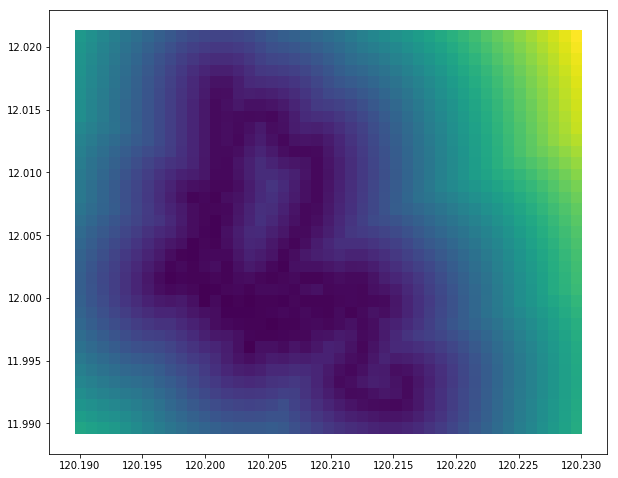

In [76]:
ax = shp1.plot(column='total_scho', cmap='viridis',figsize=[10,10] )

In [54]:
nx.single_source_dijkstra_path_length?

### Testing

In [8]:
string = 'Bethlehem'

In [9]:
poly = get_polygon(string)

if poly == -1:
    boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=2)
    xmin = boundary_GDF.bbox_west[0]
    xmax = boundary_GDF.bbox_east[0]
    ymin = boundary_GDF.bbox_south[0]
    ymax = boundary_GDF.bbox_north[0]
else:
    bounds = poly.bounds
    xmin = bounds[0]
    xmax = bounds[2]
    ymin = bounds[1]
    ymax = bounds[3]

boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=1)

osm_schools = get_amenities(string, 'schools')
osm_schools.to_crs({'init': 'epsg:3857'})
osm_hosp = get_amenities(string, 'healthcare')
osm_hosp.to_crs({'init': 'epsg:3857'})

crs = get_crs(string)

G_drive = get_graph(string,boundary_GDF, 'drive', target_crs= crs)


/nfshome/gb1877/.conda/envs/osm2/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nfshome/gb1877/.conda/envs/osm2/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Saving OSM data to shapefile at path data/Bethlehem
Saving OSM data to shapefile at path data/Bethlehem
Fetching graph data for Bethlehem
peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Identified 3242 unique edge(s) longer than 50. 
Beginning new node creation...
32482 new edges added and 6181 removed to bring total edges to 34614
12999 new nodes added to bring total nodes to 16652


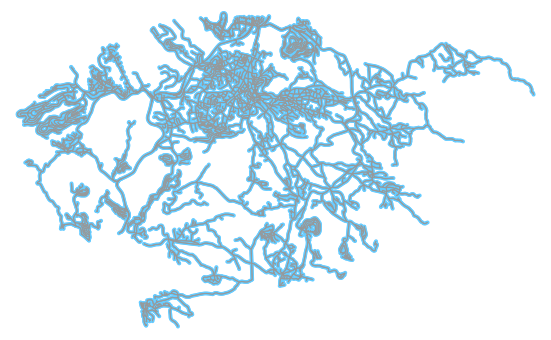

(<Figure size 835.298x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f33134c4d68>)

In [39]:
ox.plot_graph(G_drive)

In [41]:
G_ = ox.project_graph(G_drive, to_crs = {'init':'epsg:3857'})

In [10]:
nodes = ox.graph_to_gdfs(G_drive, nodes=True, edges=False)

In [11]:
nodes.crs

{'init': 'epsg:4326'}

In [37]:
crs = 'epsg:2039'

schools = gn.pandana_snap(G_drive, osm_schools,target_crs=crs, add_dist_to_node_col=True)

health = gn.pandana_snap(G_drive, osm_hosp,target_crs=crs, add_dist_to_node_col=True)


fail_value = 9999

print('Creating fishnet')


grid=gpd.read_file('data/{a}/{b}_{c}_grid.shp'.format(a=string,b=string, c='fishnet'))

grid['centroid'] = grid.geometry.centroid
grid_graph = grid[['FID', 'centroid']]
grid_graph.rename(columns = {'centroid':'geometry'}, inplace=True)
grid_graph = gpd.GeoDataFrame(grid_graph)
grid_graph.set_geometry(col='geometry', crs={'init':'epsg:3857'}, inplace=True)

grid_graph = gn.pandana_snap(G_drive, grid_graph,target_crs=crs,  add_dist_to_node_col=True)

Creating fishnet


In [24]:
schools.crs

{'init': 'epsg:4326'}

In [35]:
schools.head()

,amenity,lat,lon,name,name:en,geometry,NN,NN_dist
id,,,,,,,,
431623078,school,31.712851,35.210799,مدرسة الأخاء الأسلامية,Al Ekha'a Islamic School,POINT (35.2107993 31.7128506),431630018_1024_4874,92.164319
431623270,school,31.711804,35.191837,مدرسة مار افرام السرياني,St. Afram School,POINT (35.1918374 31.7118041),506889648,27.271029
431623819,school,31.706188,35.218765,مدرسة بيت ساحور للبنين,Beit Sahour School for Boys,POINT (35.2187651 31.7061879),431623813_1978_9975,56.628116
431623961,school,31.702420,35.219939,المدرسة الإنجيلية اللوثرية,Evangelical Lutheran School,POINT (35.2199389 31.7024198),1241878510_2126_10823,21.879470
431624343,school,31.713573,35.190709,Latin Patriarchate School (Fransees Building),NaN,POINT (35.190709 31.713573),431624299_2153_10953,14.675063


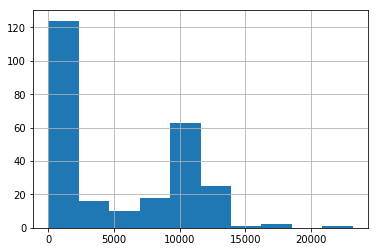

In [36]:
schools['NN_dist'].hist()

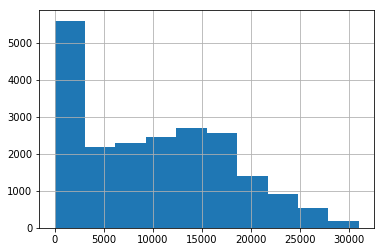

In [38]:
grid_graph['NN_dist'].hist()

In [28]:
schools_OD_drive = gn.calculate_OD(G=G_drive, origins=list(grid_graph.NN), destinations = list(schools.NN), 
                                 fail_value = fail_value, weight='distance')

print origins type
<class 'list'>
weighted_origins equals false


In [29]:
schools_OD_drive[0]

array([256., 203., 283., 282., 203., 289., 223., 222., 235., 257., 442.,
       185., 283., 170., 180., 230., 230., 388., 418., 411., 383., 337.,
       366., 144.,  56., 336., 402., 453., 334., 304., 208., 427., 431.,
       487., 487., 429., 389., 140., 423., 453., 530., 509., 498., 166.,
       162., 126., 124., 348., 318., 338., 334., 304., 224., 209., 174.,
       284., 583., 583., 572., 588., 583., 583., 583., 556., 583., 582.,
       583., 583., 583., 583., 583., 571., 583., 583., 583., 583., 583.,
       583., 583., 583., 567., 583., 583., 570., 230., 583., 588., 583.,
       583., 583., 583., 583., 583., 583., 583., 583., 583., 583., 583.,
       583., 583., 588., 583., 583., 583., 572., 583., 583., 583., 583.,
       583., 583., 583., 583., 230., 583., 583., 583., 583., 260., 583.,
       583., 583., 583., 583., 583., 583., 583., 583., 583., 583., 583.,
       260., 583., 583., 583., 583., 583., 583., 583., 583., 588., 583.,
       583., 571., 583., 583., 583., 583., 583., 58

In [32]:
origins=list(grid_graph.NN)
destinations = list(schools.NN)

In [37]:
len(origins), len(destinations)

(260, 20776)

In [34]:
if len(origins) > len(destinations):
    flip = 1
    o_2 = destinations
    destinations = origins
    origins = o_2

In [38]:
OD = np.zeros((len(origins), len(destinations)))

In [39]:
OD[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
results_dict = nx.single_source_dijkstra_path_length(G_, origins[0], cutoff = None, weight = 'distance')

In [43]:
results_dict

{'431630018_1024_4874': 0,
 '431630018_1023_4873': 1,
 '431630018_1025_4875': 1,
 431630018: 2,
 '431630018_1026_4876': 2,
 '431630018_1022_4864': 3,
 '431630018_1024_4885': 3,
 '431630018_1027_4877': 3,
 '431630018_1023_4865': 4,
 431633537: 4,
 '431630018_1028_4878': 4,
 '431630018_1024_4866': 5,
 '431633528_2441_12415': 5,
 '431633530_2445_12427': 5,
 '431630018_1029_4879': 5,
 '431630018_1025_4867': 6,
 '431633528_2440_12414': 6,
 '431633530_2444_12426': 6,
 '431630018_1030_4880': 6,
 '431630018_1026_4868': 7,
 '431633528_2439_12413': 7,
 '431633530_2443_12425': 7,
 '431630018_1031_4881': 7,
 '431630018_1027_4869': 8,
 431633528: 8,
 '431633530_2442_12424': 8,
 '431630018_1032_4882': 8,
 '431630018_1028_4870': 9,
 5579956970: 9,
 '431633528_2438_12411': 9,
 431633530: 9,
 '431630018_1033_4883': 9,
 '431630018_1029_4871': 10,
 '5579956970_374_1866': 10,
 '5579956970_375_1874': 10,
 431633550: 10,
 '431633530_2441_12421': 10,
 '431633530_2443_12429': 10,
 507107873: 10,
 1273621918: 

In [50]:
'431630018_1024_4874' in G_.node

True

In [52]:
G_.size()

34614

In [53]:
nx.single_source_dijkstra_path_length?

In [56]:
G_.edges['431630018_1024_4874', '431630018_1024_4866', 0]

KeyError: '431630018_1024_4866'

In [58]:
list(G_.edges(data=True))

[(3859570691,
  '3859570691_1_0',
  {'Wkt': <shapely.geometry.linestring.LineString at 0x7f8895a163c8>,
   'length': 49.0}),
 (726794247,
  '726794247_2_4',
  {'Wkt': <shapely.geometry.linestring.LineString at 0x7f8894427f98>,
   'length': 50.0}),
 (726794247,
  '726794247_3_18',
  {'Wkt': <shapely.geometry.linestring.LineString at 0x7f8899c1f2b0>,
   'length': 50.0}),
 (726794247,
  '726794247_4_23',
  {'Wkt': <shapely.geometry.linestring.LineString at 0x7f8899c4ff98>,
   'length': 50.0}),
 (525795337,
  431626371,
  {'osmid': 384338945,
   'name': 'כביש 60 הישן',
   'highway': 'secondary',
   'oneway': False,
   'length': 49.455,
   'Wkt': <shapely.geometry.linestring.LineString at 0x7f8829ca27b8>}),
 (525795337,
  '525795337_5_39',
  {'Wkt': <shapely.geometry.linestring.LineString at 0x7f8899c4f438>,
   'length': 49.0}),
 (525795337,
  '525795337_6_43',
  {'Wkt': <shapely.geometry.linestring.LineString at 0x7f8894389780>,
   'length': 50.0}),
 (4036509707,
  '4036509707_7_45',
  {'W

In [59]:
edge = ox.graph_to_gdfs(G_, nodes=False, edges=True)

In [64]:
edge.head()

,Wkt,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,u,v,width
0,LINESTRING (35.14552669750174 31.6593564985731...,LINESTRING (3912382.135905401 3718678.46617900...,NaN,NaN,0,NaN,49.000,NaN,NaN,NaN,NaN,NaN,NaN,3859570691,3859570691_1_0,NaN
1,LINESTRING (35.10951429750111 31.7021213985731...,LINESTRING (3908373.253875158 3724272.63286204...,NaN,NaN,0,NaN,50.000,NaN,NaN,NaN,NaN,NaN,NaN,726794247,726794247_2_4,NaN
2,LINESTRING (35.10951429750111 31.7021213985731...,LINESTRING (3908373.253875158 3724272.63286204...,NaN,NaN,0,NaN,50.000,NaN,NaN,NaN,NaN,NaN,NaN,726794247,726794247_3_18,NaN
3,LINESTRING (35.10951429750111 31.7021213985731...,LINESTRING (3908373.253875158 3724272.63286204...,NaN,NaN,0,NaN,50.000,NaN,NaN,NaN,NaN,NaN,NaN,726794247,726794247_4_23,NaN
4,"LINESTRING (35.1880059 31.6983643, 35.1884836 ...",LINESTRING (3917110.898818707 3723781.05541410...,secondary,NaN,0,NaN,49.455,NaN,כביש 60 הישן,False,384338945,NaN,NaN,525795337,431626371,NaN


In [79]:
edge['length'].max()

746.1519999999999

In [46]:
G100 = ox.graph_from_place('Piedmont, California')

In [69]:
edge_gdf100 = ox.graph_to_gdfs(G100, nodes = False)

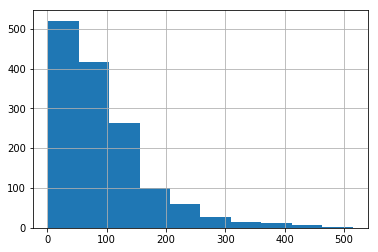

In [75]:
edge_gdf100['length'].hist()

In [68]:
pschools = get_amenities('Piedmont', 'schools')
#osm_schools.to_crs({'init': 'epsg:3857'})
phosp = get_amenities('Piedmont', 'healthcare')
#osm_hosp.to_crs({'init': 'epsg:3857'})
pschools = pschools.to_crs({'init':'epsg:3310'})

/nfshome/gb1877/.conda/envs/osm2/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nfshome/gb1877/.conda/envs/osm2/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Saving OSM data to shapefile at path data/Piedmont
Saving OSM data to shapefile at path data/Piedmont


In [52]:
phosp

,amenity,lat,lon,name,geometry


In [49]:
gn.pandana_snap?

In [59]:
pschools = gn.pandana_snap(G=G100, point_gdf = pschools,add_dist_to_node_col=True)

#phealth = gn.pandana_snap(G = G100, point_gdf = phosp, add_dist_to_node_col=True)

In [66]:
pschools

,amenity,lat,lon,name,geometry,NN,NN_dist
id,,,,,,,
358819251,school,37.822905,-122.233678,Millennium Alternate High School,POINT (-196334.7716527503 -19193.45889316499),53040794,197152.722893
358819659,school,37.813816,-122.214412,Corpus Christi School,POINT (-194665.2357171265 -20243.29319066927),53040794,195597.283346
358819748,school,37.818619,-122.211076,Zion Lutheran School,POINT (-194359.5768201756 -19716.39283243939),53040794,195239.259523


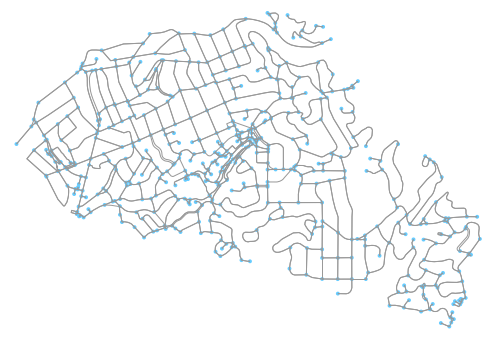

AttributeError: 'Series' object has no attribute 'geometry'

In [64]:
ax = ox.plot_graph(G100)
pschools.plot(ax=ax[1])

In [69]:
pschools

,amenity,lat,lon,name,geometry
id,,,,,
358819251,school,37.822905,-122.233678,Millennium Alternate High School,POINT (-196334.7716527503 -19193.45889316499)
358819659,school,37.813816,-122.214412,Corpus Christi School,POINT (-194665.2357171265 -20243.29319066927)
358819748,school,37.818619,-122.211076,Zion Lutheran School,POINT (-194359.5768201756 -19716.39283243939)
